In [126]:
import pandas as pd
import numpy as np
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from wordcloud import WordCloud
from scipy.stats import pearsonr
import spacy
from collections import Counter

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
  
%matplotlib notebook

## General Analysis

In [127]:
df = pd.read_csv('data/Language Detection.csv')
df.describe()

,Text,Language
count,10337,10337
unique,10267,17
top,Jag är ledsen.,English
freq,3,1385


In [128]:
df.head(10)

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
5,"[2] In ancient philosophy, natura is mostly us...",English
6,"[3][4] \nThe concept of nature as a whole, the...",English
7,During the advent of modern scientific method ...,English
8,"[5][6] With the Industrial revolution, nature ...",English
9,"However, a vitalist vision of nature, closer t...",English


In [129]:
df['Language'].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: Language, dtype: int64

<IPython.core.display.Javascript object>


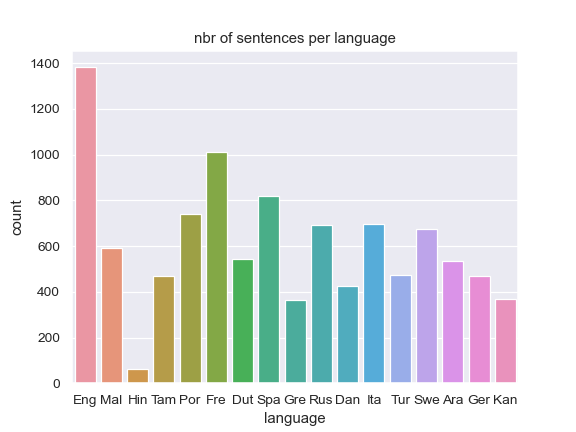

In [130]:

# Create an abbreviation for better visualisation
df['lang_abbr'] = df['Language'].str[:3]
plt.figure()

sns.set(style="darkgrid")
ax = sns.countplot(x="lang_abbr", data=df)
ax.set(xlabel="language", ylabel="count", title="nbr of sentences per language")  

plt.show()

From the value count and the bar chart, we conclude that the most represented language is English, while Hindi is the least represented. The Italian Language, the positive class for the binary classifier, is the 5th most represented language and only accounts for **7% of the data**. This inbalance could have a detrimental effect on the performance of the model. The possible solutions for that is to downsample the negative/ not italian class, use a metric that is immune to the imbalance, like the F1-score, or do weighting the classes. **In this project, I am going to opt for downsampling and using the F1-score.**

In [131]:
def sample_sentences(df, n):
    """
    Objective: Print n samples from each language
    """
    grouped = df.groupby('Language')
    samples = []
    
    for lang, group in grouped:
        # sample n sentences from the group
        indices = np.random.choice(len(group), n, replace=False)
        sentences = group.iloc[indices]['Text']
        
        # add the sentences to the list of samples
        samples.extend([(lang, sentence) for sentence in sentences])
    
    # print out the samples in a nice format
    for i, sample in enumerate(samples):
        print(f"Sample {i+1}:")
        print(f"Language: {sample[0]}")
        print(f"Sentence: {sample[1]}")
        print("-"*20)

In [132]:
sample_sentences(df, 3)

Sample 1:
Language: Arabic
Sentence: بطريقة فظيعة أحيانًا في السجون الفظيعة تستخدم أيضًا في الحياة اليومية للحديث عن بعض الأعمال الخاطئة الشائعة وتريد المبالغة فيها.
--------------------
Sample 2:
Language: Arabic
Sentence: تجنب السؤال.
--------------------
Sample 3:
Language: Arabic
Sentence: أنا سأخذه.
--------------------
Sample 4:
Language: Danish
Sentence: torsdag den 28. januar 2021 har den engelsksprogede Wikipedia 6.237.605 artikler, 141.020 aktive bidragydere og 1.115 administratorer.
--------------------
Sample 5:
Language: Danish
Sentence: nej, undskyld, jeg har allerede gale nogle planer.
--------------------
Sample 6:
Language: Danish
Sentence: spørger jeg og så siger jeg til sidst.
--------------------
Sample 7:
Language: Dutch
Sentence: ik ben het 100% met je eens.
--------------------
Sample 8:
Language: Dutch
Sentence: In vergelijking met traditionele encyclopedieën is er dan ook meer aandacht voor sporters, informatica en popcultuur, terwijl onderwerpen als natuurwete

After Sampling 3 sentences per language. We conclude, that the data comes from multiple sources. In addition to that we 

AVG word count for Eng: 136
AVG word count for Mal: 99
AVG word count for Hin: 1209
AVG word count for Tam: 105
AVG word count for Por: 139
AVG word count for Fre: 145
AVG word count for Dut: 99
AVG word count for Spa: 130
AVG word count for Gre: 106
AVG word count for Rus: 112
AVG word count for Dan: 91
AVG word count for Ita: 142
AVG word count for Tur: 88
AVG word count for Swe: 118
AVG word count for Ara: 99
AVG word count for Ger: 74
AVG word count for Kan: 87


<IPython.core.display.Javascript object>


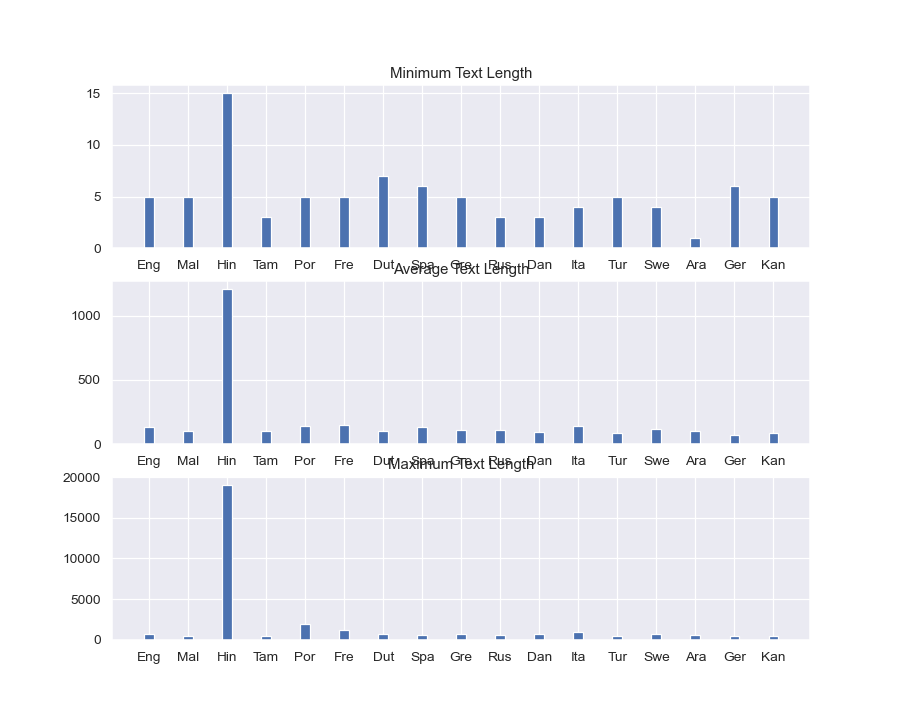

In [133]:
def plot_text_length(df):
    languages = df['lang_abbr'].unique()
    min_vals = []
    max_vals = []
    avg_vals = []
    
    for lang in languages:
        lang_df = df[df['lang_abbr'] == lang]
        min_vals.append(lang_df['Text'].apply(len).min())
        max_vals.append(lang_df['Text'].apply(len).max())
        avg_vals.append(lang_df['Text'].apply(len).mean())
        print(f'AVG word count for {lang}: {int(avg_vals[-1])}')
    ind = np.arange(len(languages))
    width = 0.25
    
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    ax[0].bar(ind, min_vals, width)
    ax[0].set_xticks(ind)
    ax[0].set_xticklabels(languages)
    ax[0].set_title('Minimum Text Length')
    
    ax[1].bar(ind, avg_vals, width)
    ax[1].set_xticks(ind)
    ax[1].set_xticklabels(languages)
    ax[1].set_title('Average Text Length')
    
    ax[2].bar(ind, max_vals, width)
    ax[2].set_xticks(ind)
    ax[2].set_xticklabels(languages)
    ax[2].set_title('Maximum Text Length')
    
plot_text_length(df)

The above bar charts show the min, avg, and max of document length per language. We deduce the following:
* There are no empty setences
* All the languages have close values except for hindi, where sentences tend to be more lengthy

### Preprocessing

In [134]:
import re

def pre_process(data, text_var='Text'):
    """
    Objective: pre-process the data to get rid of hashtags, mentions, usrs of the text_var. it remove numbers, unidecode emojis
                duplicated tokens or punctuations, 

    Inputs:
        - data, pd.DataFrame: dataset to pre-process
        - text_var, str: the variable of text in the dataframe
    Outputs:
        - data, pd.DataFrame: dataset pre-processed
    """
    #quit url
    data.loc[:, 'text_pp'] = data.loc[:, text_var].apply(lambda x: 
                re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', x))

    #quit HT
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x:  re.sub(r'(#\w+)', 'HTG', x))

    #quit mentiosn
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x:  re.sub(r'(@\w+)', 'USR', x))

    #quit unicode
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: removeUnicode(x).replace('\'', '’'))
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: 
                                                x.replace('\x92', '’').replace('ŕ', 'à').replace('č', 'è'))

    #remove emojis
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: get_emojis(x, token='')).values

    #remove duplicated tokens
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: re.sub(r'\b(\w+)(?:\W+\1\b)+', r'\1',
                                                                       x, flags=re.IGNORECASE))
    #remove htg with - or _ between it
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: re.sub(r'htg[-_]\w+', r'htg',
                                                                       x, flags=re.IGNORECASE))

    #remove numbers
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: removeNumbers(x).replace('\\n', ' ').strip())
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: re.sub(
                        r'num[,.]num', 'num', 
                        x.replace('  ', ' ').strip()).strip())

    #remove weird unicode
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: 
                                                          re.sub(r'(?:\\xe|\\xa)', '', x).replace('  ', ' ').strip())

    #remove sequences url htg usr in random orders
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: 
                                                          re.sub(r'^((url\s*)*(?:usr|htg)\b[\s\n]*(url\s*)*){1,}',
                                                                           '', x).strip())
    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: 
                                                          re.sub(r'((url\s*)*(?:usr|htg)\b[\s\n]*(url\s*)*){1,}$',
                                                                           '', x).strip())

    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: re.sub(
                        r'^((?:num|url)*(?:usr|htg)\b[\s\n]*(?:num|url)*){1,}', '', 
                        x.replace('  ', ' ').strip()).strip())

    data.loc[:, 'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: re.sub(
                        r'url$', '', 
                        x.replace('  ', ' ').strip()).strip())    

    # remove punctuation
    data.loc[:,'text_pp'] = data.loc[:, 'text_pp'].apply(lambda x: removePunct(x))
    
    #remove stop words in italian
    #data.loc[data['Language'] == "Italian", "text_pp"] = data.loc[data['Language'] == "Italian", "text_pp"].apply(lambda x: removeStopWords(x))
    return data

def removeUnicode(text):
    """ Removes unicode strings like "\u002c" printable such as \t \r and \n"""
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'&amp;','&', text.replace('\t', ' ').replace('\r', ' ').replace('\n', ' ')).strip()
    return text


def get_emojis(text, token=' EMOJI '):
    """
    Objectives: get all emojis from the text an replace it by a token
    
    Inputs:
        - text, str: the text to clean
        - token, str: the token to replace emoji with
    Outputs:
        - text, str: the cleaned text
        - emojis, list: the list of emojis
    """
    EMOJI_PATTERN = re.compile(
                            "["
                            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "\U0001F300-\U0001F5FF"  # symbols & pictographs
                            "\U0001F600-\U0001F64F"  # emoticons
                            "\U0001F680-\U0001F6FF"  # transport & map symbols
                            "\U0001F700-\U0001F77F"  # alchemical symbols
                            "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                            "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                            "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                            "\U0001FA00-\U0001FA6F"  # Chess Symbols
                            "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                            "\U00002702-\U000027B0"  # Dingbats
                            "\U000024C2-\U0001F251" 
                            "]+"
                        )
    
    emojis = re.findall(EMOJI_PATTERN, text) + re.findall(r'\\u\w+', text.encode('unicode_escape').decode('ascii'))
    text = re.sub(EMOJI_PATTERN, token, text)
    text = re.sub(r'\\[uU]\w+', '', text.encode('unicode_escape').decode('ascii'))
    return text


def removeNumbers(text):
    """
    Objective: pre-process the numbers within the text
    """

    text = re.sub(r'\d+', '', text)
    
    return text

def removePunct(text):
    """
    Objective: Remove all punctuations
    """
    return text.translate(str.maketrans('', '', string.punctuation))

def removeStopWords(text, lang="italian"):
    stop_words = set(stopwords.words(lang))
    word_tokens = word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w.lower() in stop_words]
    return " ".join(filtered_text)

In [135]:
df = pre_process(df, text_var="Text")
df.to_csv('data/pp_languages.csv')

In [136]:
df.head(10)

,Text,Language,lang_abbr,text_pp
0,"Nature, in the broadest sense, is the natural...",English,Eng,Nature in the broadest sense is the natural ph...
1,"""Nature"" can refer to the phenomena of the phy...",English,Eng,Nature can refer to the phenomena of the physi...
2,"The study of nature is a large, if not the onl...",English,Eng,The study of nature is a large if not the only...
3,"Although humans are part of nature, human acti...",English,Eng,Although humans are part of nature human activ...
4,[1] The word nature is borrowed from the Old F...,English,Eng,The word nature is borrowed from the Old Fren...
5,"[2] In ancient philosophy, natura is mostly us...",English,Eng,In ancient philosophy natura is mostly used a...
6,"[3][4] \nThe concept of nature as a whole, the...",English,Eng,The concept of nature as a whole the physical...
7,During the advent of modern scientific method ...,English,Eng,During the advent of modern scientific method ...
8,"[5][6] With the Industrial revolution, nature ...",English,Eng,With the Industrial revolution nature increas...
9,"However, a vitalist vision of nature, closer t...",English,Eng,However a vitalist vision of nature closer to ...


In [137]:
df[df["Language"]=="Italian"].head(10)

,Text,Language,lang_abbr,text_pp
7114,Nature è una delle più antiche ed importanti r...,Italian,Ita,Nature una delle pixf antiche ed importanti ri...
7115,[1] Viene pubblicata fin dal 4 novembre 1869.,Italian,Ita,Viene pubblicata fin dal novembre
7116,[2] Nonostante la maggior parte delle riviste ...,Italian,Ita,Nonostante la maggior parte delle riviste del...
7117,"Molti sono gli avanzamenti e le scoperte, prov...",Italian,Ita,Molti sono gli avanzamenti e le scoperte prove...
7118,Il fattore di impatto (impact factor) di quest...,Italian,Ita,Il fattore di impatto impact factor di questa ...
7119,"[3] Oltre a Nature stesso, ci sono tre famigli...",Italian,Ita,Oltre a Nature stesso ci sono tre famiglie di...
7120,Secondo Randy Schekman l'incentivo più forte n...,Italian,Ita,Secondo Randy Schekman l pixf forte nella rice...
7121,Questo perché le grandi riviste scientifiche t...,Italian,Ita,Questo perch le grandi riviste scientifiche te...
7122,Nell'articolo Randy Schekman critica sia la se...,Italian,Ita,Nell Randy Schekman critica sia la selezione a...
7123,"Questo influenza l'attività di ricerca, in qua...",Italian,Ita,Questo influenza l di ricerca in quanto la ind...


## Train/Test split & Analysis

In [138]:
def split_data(df, train=0.8, lang_chunk=75):
    # Filter the Italian data and split into train and test sets
    italian_df = df[df['Language'] == 'Italian']
    italian_train, italian_test = train_test_split(italian_df, train_size=train, random_state=42)

    # Filter the non-Italian data and split into train and test sets
    non_italian_df = df[df['Language'] != 'Italian']
    non_italian_train = pd.DataFrame()
    non_italian_test = pd.DataFrame()
    for lang in non_italian_df['Language'].unique():
        lang_df = non_italian_df[non_italian_df['Language'] == lang]
        
        if len(lang_df) >=lang_chunk:
            lang_train, lang_test = train_test_split(lang_df, train_size=int(lang_chunk*train), test_size=int(lang_chunk*(1-train)), random_state=42)
            non_italian_train = pd.concat([non_italian_train, lang_train])
            non_italian_test = pd.concat([non_italian_test, lang_test])
        else:
            lang_train, lang_test = train_test_split(lang_df, train_size=train, random_state=42)
            non_italian_train = pd.concat([non_italian_train, lang_train])
            non_italian_test = pd.concat([non_italian_test, lang_test])
    # Combine the Italian and non-Italian train and test sets
    train_df = pd.concat([italian_train, non_italian_train])
    test_df = pd.concat([italian_test, non_italian_test])

    return train_df, test_df

In [139]:
train_df, test_df = split_data(df)

In [140]:
train_df['Language'].value_counts()

Italian       558
Greek          60
German         60
Arabic         60
Sweedish       60
Turkish        60
Danish         60
Russian        60
Spanish        60
English        60
Dutch          60
French         60
Portugeese     60
Tamil          60
Malayalam      60
Kannada        60
Hindi          50
Name: Language, dtype: int64

In [141]:
test_df['Language'].value_counts()

Italian       140
Greek          14
German         14
Arabic         14
Sweedish       14
Turkish        14
Danish         14
Russian        14
Spanish        14
English        14
Dutch          14
French         14
Portugeese     14
Tamil          14
Malayalam      14
Kannada        14
Hindi          13
Name: Language, dtype: int64

### Visualize word frequency distribution

In [142]:
# Italian Text
train_italian = train_df.loc[train_df['Language'] == "Italian"]
train_italian_texts = train_italian['text_pp'].astype(str).tolist()
test_italian = test_df.loc[test_df['Language'] == "Italian"]
test_italian_texts = test_italian['text_pp'].astype(str).tolist()

# Not-italian text
train_not_italian = train_df.loc[train_df['Language'] != "Italian"]
train_not_italian_texts = train_not_italian['text_pp'].astype(str).tolist()
test_not_italian = test_df.loc[test_df['Language'] != "Italian"]
test_not_italian_texts = test_not_italian['text_pp'].astype(str).tolist()


In [143]:
def plot_word_frequency(texts, title=""):
    fig = plt.figure()
    #combine texts
    texts = " ".join(texts)
    
    #tokenize
    tokens = nltk.word_tokenize(texts)
    
    #compute the frequency
    freq = nltk.FreqDist(tokens)
    
    #plot
    freq.plot(30, cumulative=False)
    fig.suptitle(title)
    plt.show()

<IPython.core.display.Javascript object>


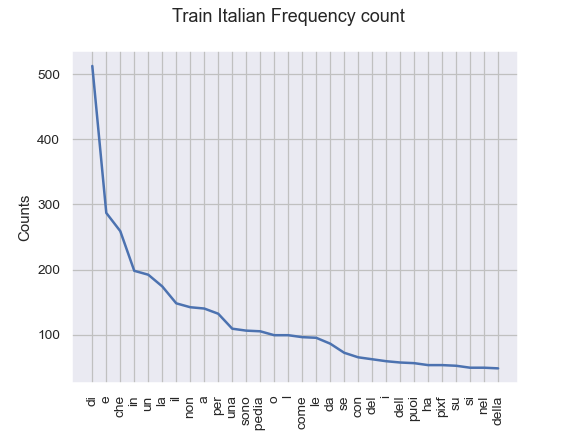

In [144]:
plot_word_frequency(texts=train_italian_texts, title="Train Italian Frequency count")

<IPython.core.display.Javascript object>


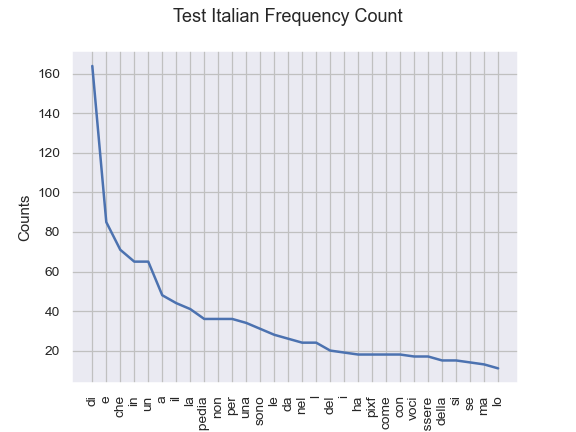

In [145]:
plot_word_frequency(texts=test_italian_texts, title='Test Italian Frequency Count')

<IPython.core.display.Javascript object>


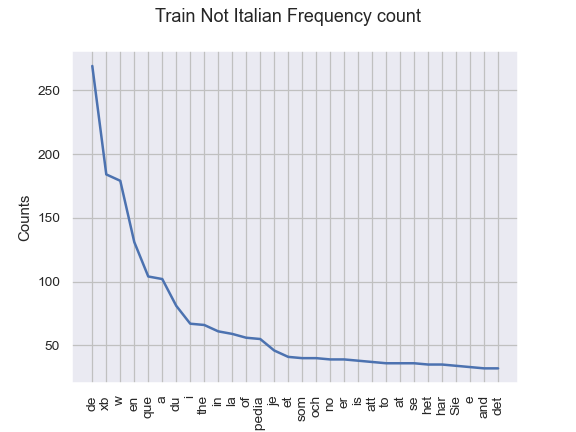

In [146]:
plot_word_frequency(texts=train_not_italian_texts, title="Train Not Italian Frequency count")

<IPython.core.display.Javascript object>


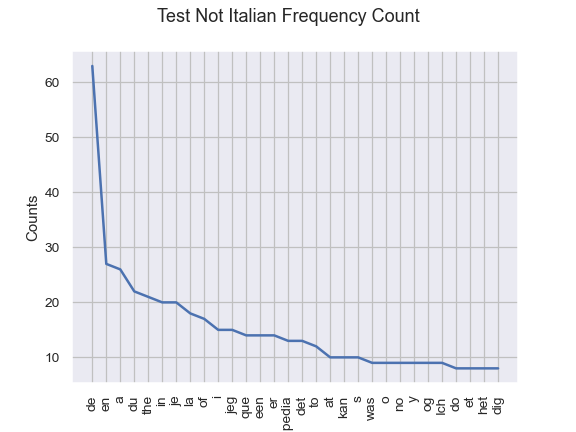

In [147]:
plot_word_frequency(texts=test_not_italian_texts, title='Test Not Italian Frequency Count')

### Identify most common words

In [148]:
def create_word_cloud(texts, title=""):
    #combine texts
    texts = " ".join(texts)
    
    #tokenize
    tokens = nltk.word_tokenize(texts)
    
    #compute the frequency
    freq = nltk.FreqDist(tokens)
    
    #create a word cloud
    cloud = WordCloud(width=800, height=800, background_color='white', 
                          max_words=50, contour_width=3, contour_color='steelblue')
    cloud.generate_from_frequencies(freq)
    
    # Display the word cloud
    fig = plt.figure()
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    fig.suptitle(title)

    plt.show()

<IPython.core.display.Javascript object>


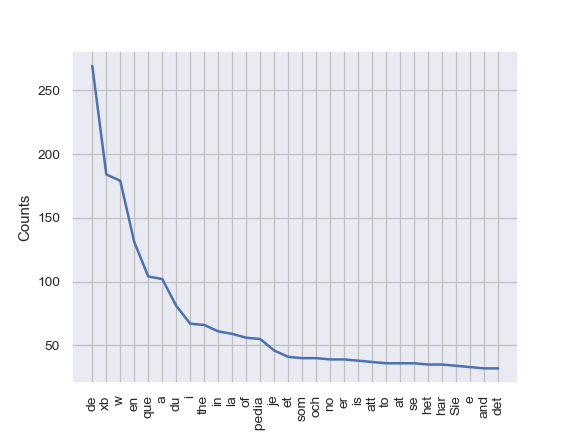

In [149]:
plot_word_frequency(texts=train_not_italian_texts)

<IPython.core.display.Javascript object>


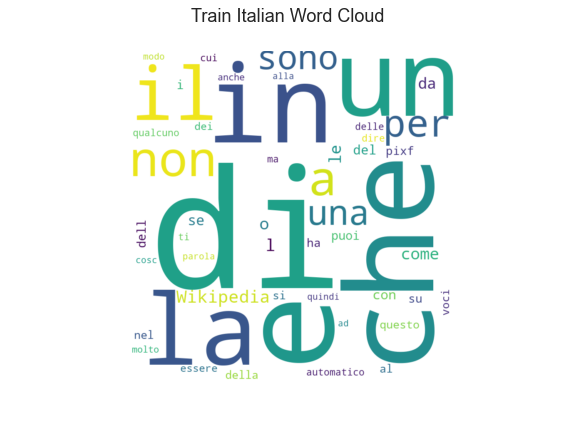

In [150]:
create_word_cloud(train_italian_texts, "Train Italian Word Cloud")

<IPython.core.display.Javascript object>


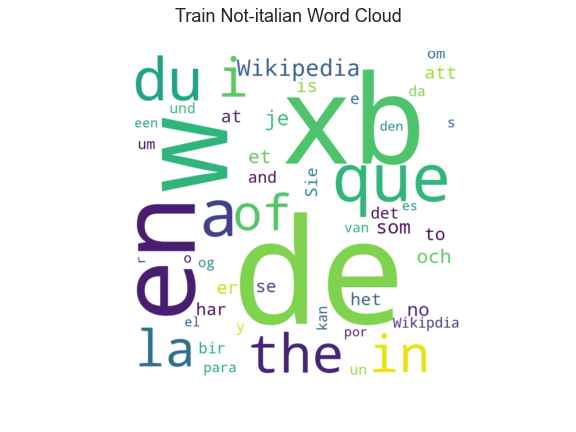

In [151]:
create_word_cloud(train_not_italian_texts, title="Train Not-italian Word Cloud")

<IPython.core.display.Javascript object>


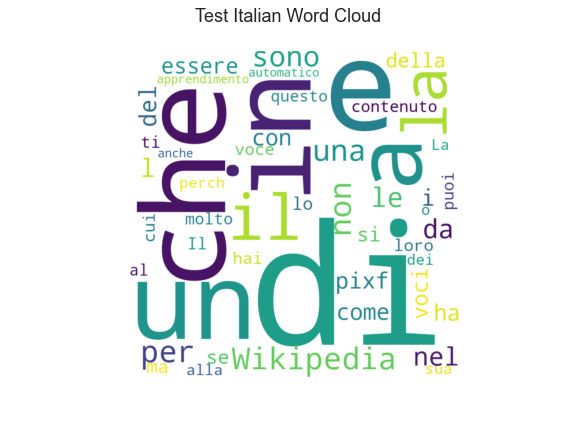

In [152]:
create_word_cloud(test_italian_texts, "Test Italian Word Cloud")

<IPython.core.display.Javascript object>


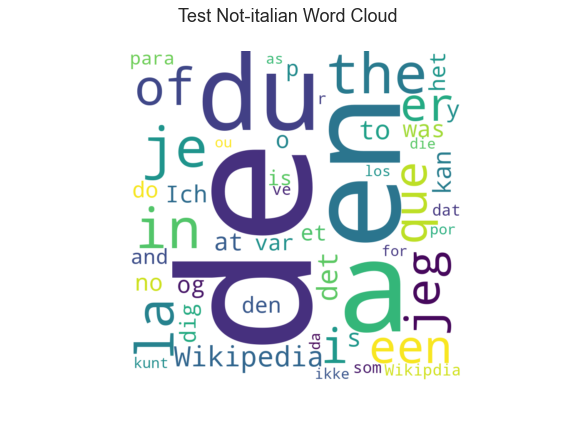

In [153]:
create_word_cloud(test_not_italian_texts, title="Test Not-italian Word Cloud")

From the previous plots and word clouds we withdraw the following conclusion:
- The train set and test set have similar recurring words in Italian in addition the distribution of words is quite different. This means that the test set and train set contains different words and sentences, which will lead to a better evaluation of the model
- The sentences are dominated by stop words. Usually, stop words are removed in the cleaning process, as they don't convey much meaning. However, in our case it will be helpful, since we are classifying the language.

- Wikipedia is present in all word clouds, this means that a good chunk of documents are from Wikipedia. I will remove the word wikipedia from all the sentences

In [166]:
def removeCustomStopWords(text, stop_words=[]):
    words = text.values[0].split(' ')
    filtered_text = [w for w in words if not w.lower() in stop_words]
    return " ".join(filtered_text)

In [167]:
df.loc[:, "text_pp"] = df.loc[: "text_pp"].apply(lambda x: removeCustomStopWords(x, stop_words=['wikipedea']))


### Check for patterns or trends

In [154]:
def get_pos_counts(texts):
    # Load the Italian language model from spaCy
    nlp = spacy.load('it_core_news_sm')
    
    # Process each text and extract the parts of speech
    pos_counts = Counter()
    for text in texts:
        doc = nlp(text)
        pos_counts.update([token.pos_ for token in doc])
    
    return pos_counts

In [155]:
def explore_text_patterns(italian_texts, other_texts):

    #join all texts
    texts = italian_texts + other_texts

    #tokenize
    tokenized_texts = [nltk.word_tokenize(text) for text in texts if len(nltk.word_tokenize(text)) > 0]
    tokenized_it_texts = [nltk.word_tokenize(text) for text in italian_texts if len(nltk.word_tokenize(text)) > 0]
    
    #average length of the texts
    avg_length = sum(len(tokenized_text) for tokenized_text in tokenized_texts) / len(tokenized_texts)
    print(f"Average text length: {avg_length:.2f} words")
   
    #average word length in the texts
    word_lengths = [len(word) for tokenized_text in tokenized_texts for word in tokenized_text]
    avg_word_length = sum(word_lengths) / len(word_lengths)
    print(f"Average word length: {avg_word_length:.2f} characters")

    #average word length in each sentence
    word_lengths_per_sentence = [[len(word) for word in tokenized_text] for tokenized_text in tokenized_texts]
    avg_word_length_per_sentence = [sum(sentence) / len(sentence) for sentence in word_lengths_per_sentence]

    all_words = [word.lower() for tokenized_text in tokenized_texts for word in tokenized_text]
    freq = nltk.FreqDist(all_words)
    all_words_italian = [word.lower() for tokenized_it_text in tokenized_it_texts for word in tokenized_it_text]
   
    #most common bigrams
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = nltk.collocations.BigramCollocationFinder.from_words(all_words)
    finder.apply_freq_filter(5)
    bigrams = finder.nbest(bigram_measures.pmi, 10)
    print(f"Most common bigrams: {bigrams}")
   
    #most common trigrams
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    finder = nltk.collocations.TrigramCollocationFinder.from_words(all_words)
    finder.apply_freq_filter(5)
    trigrams = finder.nbest(trigram_measures.pmi, 10)
    print(f"Most common trigrams: {trigrams}")
   
    #average number of italian stopwords in the texts
    stopwords = set(nltk.corpus.stopwords.words('italian'))
    all_words_italian = [word.lower() for text in tokenized_it_texts for word in text]
    num_stopwords = [len([word for word in text if word.lower() in stopwords]) for text in tokenized_it_texts]
    avg_num_stopwords = sum(num_stopwords) / len(num_stopwords)
    print(f"Average number of Italian stopwords: {avg_num_stopwords:.2f}")
   

     #most common parts of speech in the Italian texts
    pos_counts = get_pos_counts(texts= italian_texts)
    print(f"Most common parts of speech in Italian texts: {pos_counts.most_common(5)}")
   
    #correlation between italian text length and number of stopwords
    corr, p = pearsonr([len(text) for text in tokenized_it_texts], num_stopwords)
    print(f"Correlation between Italian text length and number of stopwords: {corr:.2f}, p-value: {p:.2f}")
   
    #correlation between text length and average word length
    corr, p = pearsonr([len(text) for text in tokenized_texts], avg_word_length_per_sentence)
    print(f"Correlation between text length and average word length: {corr:.2f}, p-value: {p:.2f}")


In [156]:
print("For train set:")
explore_text_patterns(italian_texts=train_italian_texts, other_texts=train_not_italian_texts)
print('-'*25)
print("For test set:")
explore_text_patterns(italian_texts=test_italian_texts, other_texts=test_not_italian_texts)


For train set:
Average text length: 19.40 words
Average word length: 5.02 characters
Most common bigrams: [('linee', 'guida'), ('reti', 'neurali'), ('tuoi', 'amici'), ('riviste', 'scientifiche'), ('prossima', 'volta'), ('jimmy', 'wales'), ('larry', 'sanger'), ('data', 'mining'), ('wikimedia', 'foundation'), ('ik', 'ben')]
Most common trigrams: [('la', 'prossima', 'volta'), ('lo', 'studio', 'dell'), ('alla', 'fine', 'del'), ('altro', 'modo', 'per'), ('punto', 'di', 'vista'), ('un', 'altro', 'modo'), ('altre', 'parole', 'che'), ('che', 'puoi', 'usare'), ('ad', 'esempio', 'il'), ('xb', 'w', 'xb')]
Average number of Italian stopwords: 8.86
Most common parts of speech in Italian texts: [('NOUN', 2576), ('ADP', 2019), ('VERB', 1478), ('DET', 1347), ('ADJ', 1035)]
Correlation between Italian text length and number of stopwords: 0.97, p-value: 0.00
Correlation between text length and average word length: -0.04, p-value: 0.16
-------------------------
For test set:
Average text length: 20.83 wo